In [1]:
import pandas as pd; pd.options.mode.chained_assignment = None # default warn => SettingWithCopyWarning
import numpy as np
from datetime import datetime
import warnings; warnings.simplefilter(action='ignore', category=UserWarning)
from IPython.display import HTML, display
from ipywidgets import AppLayout, Button, Layout, VBox, HBox, Label, HTML, interact, IntSlider
import ipywidgets as widgets
import arrow

#import dmyplant2
from dmyplant2 import (
    cred, MyPlant, Engine, 
    msgFSM, filterFSM, FSMPlot_Start, 
    bokeh_show, dbokeh_chart, add_dbokeh_vlines, get_cycle_data2, 
    disp_result, alarms_pareto, warnings_pareto, states_lines,
    detect_edge_right, detect_edge_left, plot_with_additional_results)
    
cred()
mp = MyPlant(3600)
Engine._list_cached_validations()

,1486174,1320072
Asset ID,159398,117617
Validation Engine,Forsa Hartmoor M04,BMW Landshut 4.10 M4
n,999,999
oph@start,44.0,1384.0
serialNumber,1486174,1320072
starts@start,61.0,271.0
val start,2022-01-11 00:00:00,2019-01-09 00:00:00
source,from_MyPlant,from_MyPlant


In [2]:
def sfun(x):
    return all([ ("Forsa Hartmoor" in str(x['IB Site Name'])),  (x['OperationalCondition'] != 'Decommissioned') ])
fleet = mp.search_installed_fleet(sfun).drop('index', axis=1)
fleet = fleet.sort_values(by = "Engine ID",ascending=True).reset_index(drop='index')
fleet.T

,0,1,2,3,4,5,6,7,8,9,10
Count_OpHour,188.0,185.0,172.0,165.0,180.0,185.0,170.0,157.0,158.0,121.0,157.0
OperationalCondition,Available,Available,Available,Available,Available,Available,Available,Available,Available,Available,Available
shutdown_counter,136.0,105.0,98.0,99.0,99.0,97.0,91.0,85.0,90.0,82.0,93.0
startup_counter,136.0,103.0,98.0,99.0,98.0,95.0,91.0,85.0,90.0,80.0,88.0
id,159396,159397,159399,159398,159400,159401,159403,159402,159404,159405,159406
Engine Version,H12,H12,H12,H12,H12,H12,H12,H12,H12,H12,H12
Engine Type,624,624,624,624,624,624,624,624,624,624,624
Engine Series,6,6,6,6,6,6,6,6,6,6,6
Country,GB,GB,GB,GB,GB,GB,GB,GB,GB,GB,GB
Commissioning Date,2022-01-10,2022-01-10,2022-01-11,2022-01-11,2022-01-22,2022-01-10,2022-01-11,2022-01-11,2022-01-11,2022-01-22,2022-01-11


In [3]:
motor = fleet.iloc[3]
modes = ['???','OFF','MANUAL','AUTO']
success = [True,False]
#success = [True]
motor['IB Site Name'] + ' ' + motor['Engine ID'], modes, success

('Forsa Hartmoor M04', ['???', 'OFF', 'MANUAL', 'AUTO'], [True, False])

In [5]:
e=Engine.from_fleet(mp,motor)
fsm = msgFSM(e, p_from=e['Commissioning Date'], p_to=datetime.now(), successtime=300)
#fsm = msgFSM(e, p_to='2022-02-01', successtime=600)
#fsm = msgFSM(e, p_from='2022-01-26', p_to='2022-02-01', successtime=600)

fsm.run1(enforce=True) # run Finite State Machine
fsm.store()
fsm.restore()

fldstmp: 14.01.2022 10:02:44   |0008| 14.01 10:00:17 synchronize       | 14.01 10:00:25 loadramp          | on  | AUTO  | 600 14.01.2022 10:00:26 2122 Mains parallel operation
fldstmp: 14.01.2022 10:02:44   |0008| 14.01 10:00:17 synchronize       | 14.01 10:00:25 loadramp          | on  | AUTO  | 600 14.01.2022 10:02:32 9047 Target load reached
fldstmp: 15.01.2022 08:32:17   |0011| 15.01 08:29:57 synchronize       | 15.01 08:29:58 loadramp          | on  | AUTO  | 600 15.01.2022 08:29:59 1240 Group alarm - warning
fldstmp: 15.01.2022 08:32:17   |0011| 15.01 08:29:57 synchronize       | 15.01 08:29:58 loadramp          | on  | AUTO  | 600 15.01.2022 08:32:05 9047 Target load reached
fldstmp: 17.01.2022 07:32:53   |0015| 17.01 07:30:20 synchronize       | 17.01 07:30:34 loadramp          | on  | AUTO  | 600 17.01.2022 07:30:35 2122 Mains parallel operation
fldstmp: 17.01.2022 07:32:53   |0015| 17.01 07:30:20 synchronize       | 17.01 07:30:34 loadramp          | on  | AUTO  | 600 17.01.2

In [6]:
rdf = fsm.starts
rda = rdf[:].reset_index(drop='index')
rda = rda[(rda['mode'].isin(modes) & rda['success'].isin(success))].reset_index(drop='index')
display(HTML(pd.DataFrame.from_dict(e.dash, orient='index').T.to_html(escape=False, index=False)))
#rda[filterFSM.run2filter_content].round(2)
print(f"Starts: {rdf.shape[0]}, Successful: {rdf[rdf['success'] == True].shape[0]}, Failed: {rdf[rdf['success'] == False].shape[0]} => {rdf[rdf['success'] == True].shape[0]/rdf.shape[0]*100.0:3.1f}%")

HTML(value='<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th>Na…

Starts: 85, Successful: 67, Failed: 18 => 78.8%


In [7]:
rda[filterFSM.run2filter_content].round(2).fillna('')

,no,success,mode,startpreparation,starter,speedup,idle,synchronize,loadramp,cumstarttime,maxload,ramprate,targetoperation,rampdown,coolrun,runout,count_alarms,count_warnings
0,0,True,???,97.95,4.24,24.0,6.35,13.02,126.89,272.46,,,17718.31,127.73,9.99,48.58,0,0
1,1,True,???,92.73,3.84,20.03,5.56,28.36,126.82,277.35,,,584.11,127.33,9.99,48.82,0,0
2,2,False,MANUAL,442.40,,,,,,442.40,,,,,,,0,0
3,3,False,AUTO,76.68,3.84,21.8,5.54,24.14,126.83,258.82,,,254.8,127.14,9.99,48.65,0,0
4,4,False,AUTO,106.12,4.14,21.08,,,,131.34,,,,,,,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,80,True,AUTO,99.20,4.04,20.57,4.34,32.11,116.29,276.55,,,12621.07,127.55,9.98,48.96,0,0
81,81,True,AUTO,97.63,4.24,23.0,4.45,4.13,143.31,276.76,,,7223.91,127.37,9.98,48.86,0,0
82,82,True,AUTO,97.46,4.04,21.09,4.25,33.71,116.46,277.01,,,1822.12,127.24,9.98,49.04,0,0
83,83,False,AUTO,101.49,4.04,44.01,,,,149.54,,,,,,,0,0


In [8]:
fsm.results['starts'][0];

In [9]:
#Execute FSM Run 2
# fsm.restore()
# rda = fsm.run2(rda, silent=False)
# fsm.store()

In [10]:
#rdb = rda[(rda['mode'].isin(['AUTO','MANUAL'])) & ((rda['count_alarms'] > 0) | (rda['count_warnings'] > 0))]
#rdb = rda[rda['synchronize'] < 15.0]
rdb = rda
#rdb[filterFSM.run2filter_content].sort_values(by=["synchronize","loadramp"], ascending=[True,True]).round(2)

,startpreparation,speedup,idle,synchronize,loadramp,maxload,ramprate,cumstarttime,targetoperation,rampdown,coolrun,runout
count,85.00,78.00,70.00,70.00,70.00,0.0,0.0,85.00,69.00,69.00,69.00,69.00
mean,113.23,21.74,4.88,19.21,134.23,NaN,NaN,267.22,6981.69,127.08,9.99,49.01
std,78.51,4.01,0.68,14.95,19.11,NaN,NaN,71.08,5944.33,2.56,0.02,0.33
min,4.84,3.23,4.04,1.11,103.31,NaN,NaN,4.84,4.04,106.16,9.90,48.25
25%,96.23,19.79,4.34,4.43,126.40,NaN,NaN,273.74,1822.12,127.32,9.99,48.76
50%,98.52,21.51,4.60,11.76,126.99,NaN,NaN,276.36,5422.36,127.39,9.99,48.94
75%,100.90,23.61,5.45,33.81,140.47,NaN,NaN,276.91,10822.75,127.52,10.00,49.26
max,489.45,44.01,6.37,42.48,219.22,NaN,NaN,489.45,20529.05,127.73,10.09,50.08


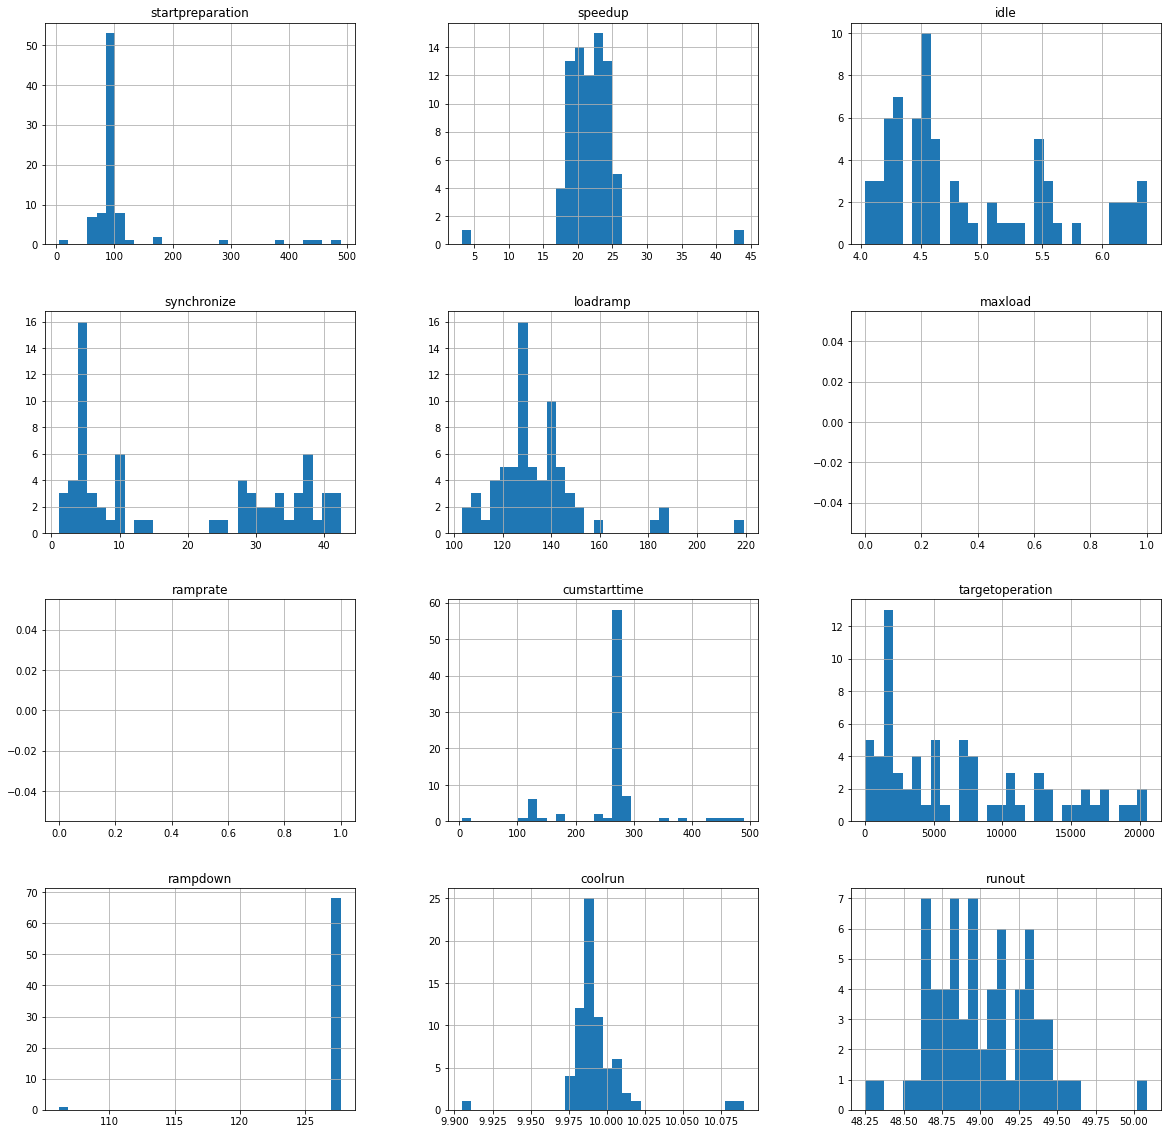

In [11]:
vec = ['startpreparation','speedup','idle','synchronize','loadramp','maxload','ramprate','cumstarttime','targetoperation','rampdown','coolrun','runout']
display(_=rdb[vec].hist(bins=30,figsize=(20,20)))
#ax_list[0][2].set_xlim((0,10))
#display(rdb[vec].hist(bins=30,figsize=(20,20)))
display(rdb[vec].describe().round(2))

In [12]:
rde = rda[(rda.starttime > fsm._e['Commissioning Date']) & (rda['success'])].copy()
rde['datetime'] = pd.to_datetime(rde['starttime'])
dfigsize = (20,12)
dset = [
    {'col':['cumstarttime'],'ylim':(-400,900), 'color':'darkblue'},
    {'col':['synchronize'],'ylim':(-20,300)},
    {'col':['startpreparation'],'ylim':(-600,300)},
    {'col':['hochlauf'],'ylim':(-100,200), 'color':'orange'},
    {'col':['loadramp'],'ylim':(-150,900), 'color':'red'},
    {'col':['ramprate'],'ylim':(-3,3)},
    {'col':['no'],'ylim':(-100,10000),'color':'black'},
    {'col':['maxload'],'ylim':(500,5000) }
]
ftitle = f"{fsm._e}"
fig = dbokeh_chart(rde, dset, style='both', figsize=dfigsize ,title=ftitle);
bokeh_show(fig)
del(fig)

In [13]:
vset = ['Various_Values_SpeedAct','Power_PowerAct','Hyd_PressCrankCase','Hyd_PressOilDif','Hyd_PressOil','Hyd_TempOil']
dset = [
    {'col':['Power_PowerAct'], 'ylim':(0,5000), 'color':'red'},
    {'col':['Various_Values_SpeedAct'],'ylim': [0, 2500], 'color':'blue'},
    #{'col':['Hyd_PressCrankCase'],'ylim': [-100, 100], 'color':'orange'},
    #{'col':['Hyd_PressOilDif'],'ylim': [0, 2], 'color':'black'},
    {'col':['Hyd_PressOil'],'ylim': [0, 10], 'color':'brown'},
    {'col':['Hyd_TempOil'],'ylim': [0, 110], 'color':'#2171b5'}
]


In [14]:
rdb[filterFSM.run2filter_content].sort_values(by=["synchronize","loadramp"], ascending=[True,True]).round(2).fillna('')

,no,success,mode,startpreparation,starter,speedup,idle,synchronize,loadramp,cumstarttime,maxload,ramprate,targetoperation,rampdown,coolrun,runout,count_alarms,count_warnings
78,78,True,AUTO,60.64,3.73,18.47,4.24,1.11,187.61,275.80,,,624.96,127.34,9.99,49.06,0,0
10,10,True,AUTO,83.17,4.24,18.88,5.45,1.31,126.51,239.56,,,19679.27,127.4,9.98,48.64,0,1
42,42,True,AUTO,100.07,3.73,19.99,4.34,1.41,146.84,276.39,,,1822.54,127.51,9.98,48.76,0,0
46,46,True,AUTO,99.97,4.22,25.34,4.94,2.62,139.3,276.40,,,1221.93,127.51,10.01,49.33,0,0
65,65,True,AUTO,97.25,3.63,23.4,4.74,2.73,144.61,276.36,,,10822.75,127.54,10.08,49.55,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,59,False,AUTO,101.39,3.64,21.51,,,,126.54,,,,,,,0,0
61,61,False,AUTO,101.50,3.64,21.6,,,,126.74,,,,,,,0,0
72,72,False,MANUAL,109.26,,,,,,109.26,,,,,,,0,0
73,73,False,AUTO,93.25,3.84,21.42,,,,118.51,,,,,,,0,0


In [15]:
def f(x=0):
    global v; v = x; startversuch = rdb.iloc[x]
    ftitle = f"{fsm._e} ----- Start {startversuch['no']} {startversuch['mode']} | {'SUCCESS' if startversuch['success'] else 'FAILED'} | {startversuch['starttime'].round('S')}"
    display(HTML(ftitle));
    disp_result(startversuch)
interact(f, x = IntSlider(0, 0, rdb.shape[0]-1 , 1, layout=widgets.Layout(width='70%')));

interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='70%'), max=84), Output()), _dom…

In [19]:
startversuch = rdb.iloc[v]; 
fig = plot_with_additional_results(fsm,startversuch, vset, dset, dfigsize=(20,12)) 
fsm.starts.iloc[v].to_dict();
bokeh_show(fig)

von: 18.01.2022 07:28:05 bis: 18.01.2022 11:18:10


In [18]:
for i, v in enumerate(fsm.runlogdetail(startversuch, statechanges_only=True)):
    print(f"{i:3} {v}")

  0 * |0046| 31.01 16:57:15 standstill        | 02.02 06:35:08 startpreparation  | off | AUTO  | 600 02.02.2022 06:35:08 1231 Request module on
  1 * |0047| 02.02 06:35:08 startpreparation  | 02.02 06:36:48 starter           | on  | AUTO  | 600 02.02.2022 06:36:48 1249 Starter on
  2 * |0047| 02.02 06:36:48 starter           | 02.02 06:36:52 speedup           | on  | AUTO  | 600 02.02.2022 06:36:52 3225 Ignition on
  3 * |0047| 02.02 06:36:52 speedup           | 02.02 06:37:17 idle              | on  | AUTO  | 600 02.02.2022 06:37:17 2124 Idle
  4 * |0047| 02.02 06:37:17 idle              | 02.02 06:37:22 synchronize       | on  | AUTO  | 600 02.02.2022 06:37:22 2139 Request Synchronization
  5 * |0047| 02.02 06:37:22 synchronize       | 02.02 06:37:25 loadramp          | on  | AUTO  | 600 02.02.2022 06:37:25 1235 Generator CB closed
  6 * |0047| 02.02 06:37:25 loadramp          | 02.02 06:39:44 targetoperation   | on  | AUTO  | 600 02.02.2022 06:39:44 9047 Target load reached (calcula

In [ ]:
mfn = e._fname + '_messages.txt'
fsm.save_messages(mfn)
print(mfn)